# Predicting Chlorophyll-A (Green color) Levels in Laguna Lake

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.kernel_ridge import KernelRidge
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# dataset directory

chlor_src = "/content/chlor.csv"

In [ ]:
# upload as dataframe

chlor_df = pd.read_csv(chlor_src)
display(chlor_df)
chlor_df.drop(columns=['Phy','NO3','NH4','Site','Bay','Depth'], inplace=True) # subset to NO2 and PO4
display(chlor_df)

,Chl_a,Phy,NO2,NO3,NH4,PO4,Site,Bay,Depth
0,6.66,0.74,0.21830,0.522735,31.784807,15.317651,XVI,West Bay,1.097
1,6.45,0.78,0.21830,0.522735,31.784807,15.317651,XVI,West Bay,1.098
2,6.27,0.77,0.21830,0.522735,31.784807,15.317651,XVI,West Bay,1.098
3,6.13,0.58,0.21495,0.527931,30.446107,14.834307,XVI,West Bay,2.004
4,6.10,0.57,0.21495,0.527931,30.446107,14.834307,XVI,West Bay,2.004
...,...,...,...,...,...,...,...,...,...
250,5.79,0.57,0.21221,0.634104,31.311913,15.862311,VIII,South Bay,3.003
251,5.26,0.55,0.21221,0.634104,31.311913,15.862311,VIII,South Bay,3.004
252,5.77,0.52,0.21221,0.634104,31.311913,15.862311,VIII,South Bay,3.007
253,5.53,0.67,0.21221,0.634104,31.311913,15.862311,VIII,South Bay,3.007


,Chl_a,NO2,PO4
0,6.66,0.21830,15.317651
1,6.45,0.21830,15.317651
2,6.27,0.21830,15.317651
3,6.13,0.21495,14.834307
4,6.10,0.21495,14.834307
...,...,...,...
250,5.79,0.21221,15.862311
251,5.26,0.21221,15.862311
252,5.77,0.21221,15.862311
253,5.53,0.21221,15.862311


,0
Chl_a,0
NO2,146
PO4,146


<Axes: >

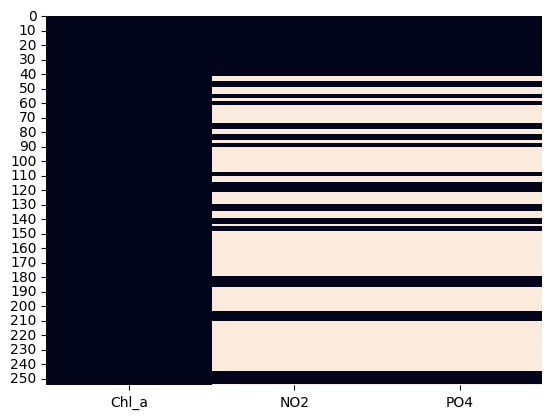

In [ ]:
# determine and visualize NaN cells

display(chlor_df.isna().sum())
sns.heatmap(chlor_df.isnull(), cbar=False)

In [ ]:
# remove rows with NaN

chlor_df.dropna(inplace=True)
display(chlor_df)

,Chl_a,NO2,PO4
0,6.66,0.21830,15.317651
1,6.45,0.21830,15.317651
2,6.27,0.21830,15.317651
3,6.13,0.21495,14.834307
4,6.10,0.21495,14.834307
...,...,...,...
249,5.64,0.21221,15.862311
250,5.79,0.21221,15.862311
251,5.26,0.21221,15.862311
252,5.77,0.21221,15.862311


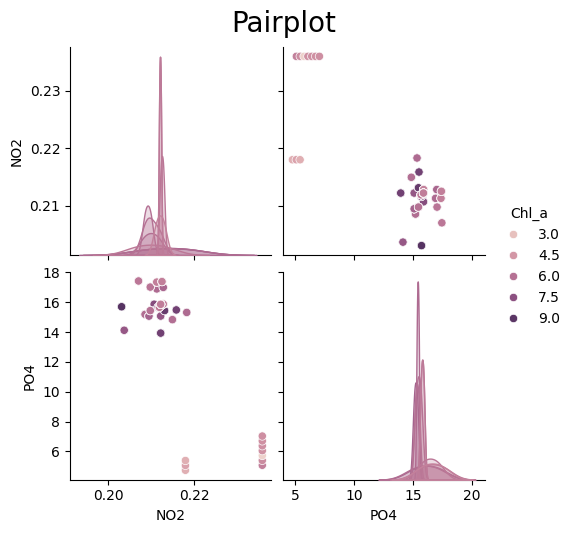

In [ ]:
# features pairplot

g = sns.pairplot(chlor_df, hue='Chl_a')
g.fig.suptitle('Pairplot', y=1.05, fontsize=20)
plt.show()

In [ ]:
# train-test split 70/30

x = chlor_df.drop('Chl_a', axis=1)
y = chlor_df['Chl_a']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [ ]:
# GPR pipeline and training

gpr_model = make_pipeline(StandardScaler(),
                          GaussianProcessRegressor(kernel=RBF(length_scale=0.01),
                                                   normalize_y=False,
                                                   n_restarts_optimizer=10,
                                                   alpha=0.02**2,
                                                   random_state=0)).fit(X_train, y_train)

# printing test data RMSE

print(f'GPR Test Data RMSE: {round(rmse(y_test, gpr_model.predict(X_test)),4)}')
print(f"GPR Test Data Accuracy: {round(gpr_model.score(X_test, y_test),4)}")

GPR Test Data RMSE: 0.6375
GPR Test Data Accuracy: 0.7355


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


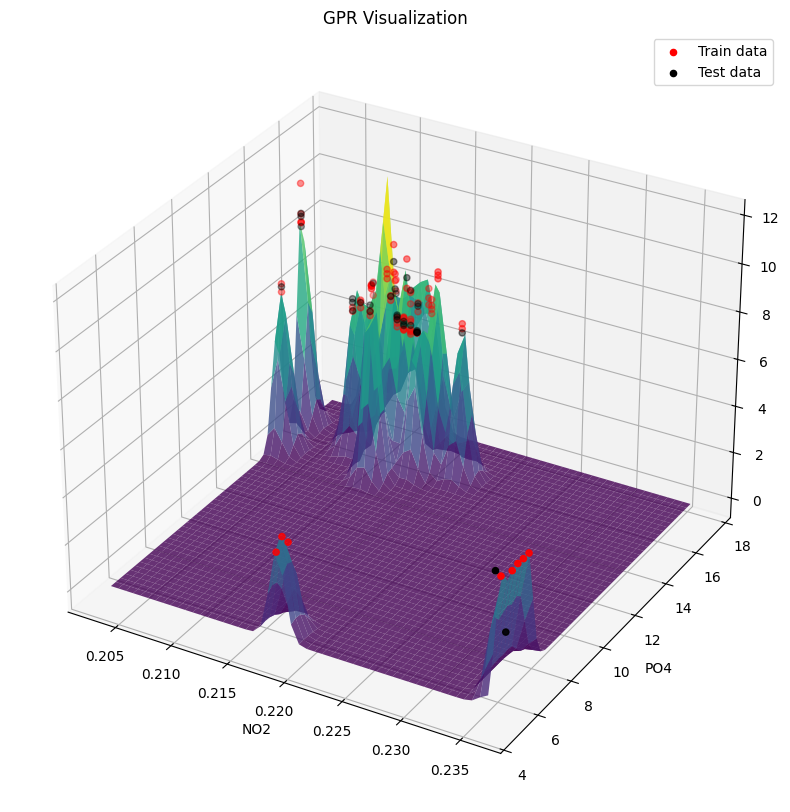

In [ ]:
# 3D GPR visualization

no2_range = np.linspace(x['NO2'].min(), x['NO2'].max(), 50)
po4_range = np.linspace(x['PO4'].min(), x['PO4'].max(), 50)
no2_grid, po4_grid = np.meshgrid(no2_range, po4_range)
x_pred = np.column_stack([no2_grid.ravel(), po4_grid.ravel()])

y_pred = gpr_model.predict(x_pred)
y_pred = y_pred.reshape(no2_grid.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(no2_grid, po4_grid, y_pred, cmap='viridis', alpha=0.8)
ax.scatter(X_train['NO2'], X_train['PO4'], y_train, color='r', label='Train data')
ax.scatter(X_test['NO2'], X_test['PO4'], y_test, color='k', label='Test data')

ax.set_xlabel('NO2')
ax.set_ylabel('PO4')
ax.set_title('GPR Visualization')
ax.legend()
plt.show()

In [ ]:
# RKK pipeline and training

krr_model = make_pipeline(StandardScaler(),
                          KernelRidge(alpha=0.01,
                                      kernel='laplacian',
                                      gamma=1,
                                      kernel_params=None)).fit(X_train, y_train)

# printing test data RMSE

print(f'KRR Test Data RMSE: {round(rmse(y_test, krr_model.predict(X_test)),4)}')
print(f"KRR Test Data Accuracy: {round(krr_model.score(X_test, y_test),4)}")

KRR Test Data RMSE: 0.4879
KRR Test Data Accuracy: 0.8451


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


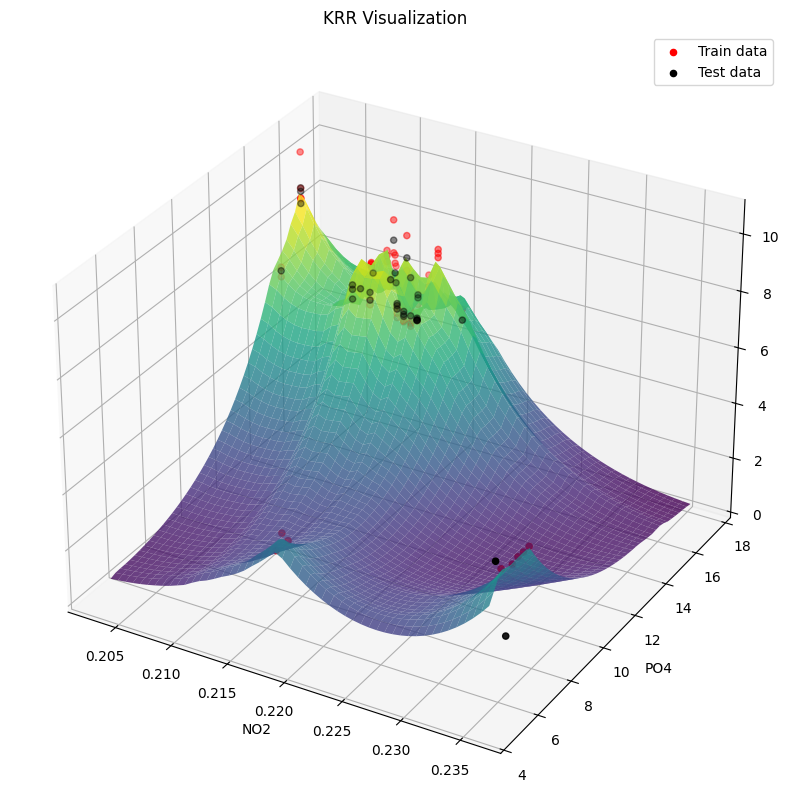

In [ ]:
# 3D KRR visualization

no2_range = np.linspace(x['NO2'].min(), x['NO2'].max(), 50)
po4_range = np.linspace(x['PO4'].min(), x['PO4'].max(), 50)
no2_grid, po4_grid = np.meshgrid(no2_range, po4_range)
x_pred = np.column_stack([no2_grid.ravel(), po4_grid.ravel()])

y_pred = krr_model.predict(x_pred)
y_pred = y_pred.reshape(no2_grid.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(no2_grid, po4_grid, y_pred, cmap='viridis', alpha=0.8)
ax.scatter(X_train['NO2'], X_train['PO4'], y_train, color='r', label='Train data')
ax.scatter(X_test['NO2'], X_test['PO4'], y_test, color='k', label='Test data')

ax.set_xlabel('NO2')
ax.set_ylabel('PO4')
ax.set_title('KRR Visualization')
ax.legend()
plt.show()

## GPR VS KRR

GPR Test Data RMSE: **0.6375**

KRR Test Data RMSE: **0.4879**

GPR Test Data Accuracy: **0.7355**

KRR Test Data Accuracy: **0.8451**

Given that KRR has a lower RMSE and higher accruacy in testing data, KRR performed better with the given dataset.